In [168]:
import pandas as pd
import matplotlib.pyplot as plt

In [169]:
taxi_small = pd.read_csv("taxi-reduced-8434").drop('Unnamed: 0',axis = 1)
taxi_med = pd.read_csv("taxi-reduced-84394").drop('Unnamed: 0',axis = 1)
taxi_large = pd.read_csv("taxi-reduced-843984").drop('Unnamed: 0',axis = 1)

## Make a cleaned version that has outliers removed

In [170]:
taxi_clean = taxi_large.copy()
# separate the date and time into separate columns
taxi_clean['pickup_datetime'] = pd.to_datetime(taxi_large['tpep_pickup_datetime'])
taxi_clean['dropoff_datetime'] = pd.to_datetime(taxi_large['tpep_dropoff_datetime'])

In [171]:
from datetime import datetime, date, timedelta
import numpy as np

# Compute ride time
taxi_clean['ride_duration'] = np.vectorize(lambda drop, pick: drop - pick)(taxi_clean['dropoff_datetime'], 
                                                                           taxi_clean['pickup_datetime'])

# Drop rides longer than 3 hours
taxi_clean.drop(taxi_clean[taxi_clean['ride_duration'] > timedelta(hours=3)].index, inplace=True)

# Drop rides less than 1 seconds
taxi_clean.drop(taxi_clean[taxi_clean['ride_duration'] < timedelta(seconds=1)].index, inplace=True)

In [172]:
 # drop rides with negative distances
taxi_clean.drop(taxi_clean[taxi_clean["trip_distance"]<0].index, inplace = True)

In [173]:
# drop rides with negative fares
taxi_clean.drop(taxi_clean[taxi_clean["fare_amount"]<=2.5].index, inplace = True)

## Begin exploratory data analysis

In [174]:
#read in key for taxi zones
taxi_zones = pd.read_csv("https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv")

In [175]:
#display zones to understand what it tells us
taxi_zones.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [176]:
taxi_zones["Zone"].value_counts()

Governor's Island/Ellis Island/Liberty Island    3
Corona                                           2
DUMBO/Vinegar Hill                               1
Battery Park                                     1
Hillcrest/Pomonok                                1
                                                ..
Financial District South                         1
Morrisania/Melrose                               1
Bedford Park                                     1
Starrett City                                    1
Spuyten Duyvil/Kingsbridge                       1
Name: Zone, Length: 261, dtype: int64

In [177]:
#display taxi data for visual aid
taxi_med.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,winter,spring,summer,fall
0,2.0,2019-01-09 00:43:42,2019-01-09 00:52:16,1.0,1.81,1.0,N,142,229,1.0,...,0.5,2.45,0.0,0.3,12.25,NaN,1,0,0,0
1,1.0,2019-01-01 04:03:20,2019-01-01 04:18:54,1.0,4.30,1.0,N,140,202,1.0,...,0.5,3.25,0.0,0.3,19.55,NaN,1,0,0,0
2,2.0,2019-01-26 02:19:33,2019-01-26 02:25:37,1.0,1.56,1.0,N,164,68,1.0,...,0.5,1.00,0.0,0.3,9.30,0.0,1,0,0,0
3,1.0,2019-01-07 16:10:33,2019-01-07 16:26:20,1.0,0.80,1.0,N,170,230,2.0,...,0.5,0.00,0.0,0.3,12.30,NaN,1,0,0,0
4,1.0,2019-01-20 08:58:48,2019-01-20 09:04:30,1.0,0.50,1.0,N,65,65,1.0,...,0.5,1.25,0.0,0.3,7.55,NaN,1,0,0,0


In [178]:
#lets analyze location v cost

#which Pickup locations end up with the highest and lowest average cost
loc_cost_group = taxi_med.groupby('PULocationID').mean()['fare_amount']
loc_cost_group = loc_cost_group.sort_values()

print('Highest Average Cost:')
max_id = loc_cost_group.index[-1]
max_borough = taxi_zones[ taxi_zones['LocationID'] == max_id ].iloc[0,1]
max_zone= taxi_zones[ taxi_zones['LocationID'] == max_id ].iloc[0,2]
print('\t Zone:', max_zone)
print('\t Borough:', max_borough)
print('\t Cost:',loc_cost_group.max() )
print()

print('Lowest Average Cost:')
min_id = loc_cost_group.index[0]
min_borough = taxi_zones[ taxi_zones['LocationID'] == min_id ].iloc[0,1]
min_zone= taxi_zones[ taxi_zones['LocationID'] == min_id ].iloc[0,2]
print('\t Zone:', min_zone)
print('\t Borough:',min_borough)
print('\t Cost:',loc_cost_group.min())

Highest Average Cost:
	 Zone: Newark Airport
	 Borough: EWR
	 Cost: 104.75

Lowest Average Cost:
	 Zone: Prospect Park
	 Borough: Brooklyn
	 Cost: 2.5


In [179]:
taxi_med.groupby('PULocationID')['fare_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
PULocationID,,,,,,,,
1,8.0,104.750000,58.301556,20.0,88.750,97.50,104.500,230.00
3,1.0,13.500000,NaN,13.5,13.500,13.50,13.500,13.50
4,141.0,12.976950,8.233845,-3.0,8.000,11.00,16.000,52.00
7,127.0,11.911102,10.572925,-2.5,4.750,7.50,16.500,49.00
8,2.0,29.750000,31.466252,7.5,18.625,29.75,40.875,52.00
...,...,...,...,...,...,...,...,...
261,483.0,17.103561,12.023754,2.5,9.000,14.50,21.000,71.50
262,1104.0,10.160226,6.528599,-6.5,6.000,8.50,12.500,60.00
263,1560.0,9.733654,7.018809,-9.5,5.000,7.50,12.000,72.00


In [180]:
#compare to drop off location.
#see if values are different
#which drop off locations have the highest and lowest average cost
loc_cost_group = taxi_med.groupby('DOLocationID').mean()['fare_amount']
loc_cost_group = loc_cost_group.sort_values()

print('Highest Average Cost:')
max_id = loc_cost_group.index[-1]
max_borough = taxi_zones[ taxi_zones['LocationID'] == max_id ].iloc[0,1]
max_zone= taxi_zones[ taxi_zones['LocationID'] == max_id ].iloc[0,2]
print('\t Zone:', max_zone)
print('\t Borough:', max_borough)
print('\t Cost:',loc_cost_group.max() )
print()

print('Lowest Average Cost:')
min_id = loc_cost_group.index[0]
min_borough = taxi_zones[ taxi_zones['LocationID'] == min_id ].iloc[0,1]
min_zone= taxi_zones[ taxi_zones['LocationID'] == min_id ].iloc[0,2]
print('\t Zone:', min_zone)
print('\t Borough:',min_borough)
print('\t Cost:',loc_cost_group.min())


Highest Average Cost:
	 Zone: Rossville/Woodrow
	 Borough: Staten Island
	 Cost: 105.0

Lowest Average Cost:
	 Zone: Saint Michaels Cemetery/Woodside
	 Borough: Queens
	 Cost: 3.375


In [181]:
taxi_med.groupby('DOLocationID')['fare_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
DOLocationID,,,,,,,,
1,166.0,71.018072,21.795321,-77.5,64.1250,68.75,75.000,230.0
3,8.0,40.148750,10.223077,27.0,34.1425,37.25,44.250,59.5
4,347.0,10.979251,7.658686,-11.5,6.2500,9.50,13.000,52.0
6,1.0,39.000000,NaN,39.0,39.0000,39.00,39.000,39.0
7,333.0,17.407748,10.518832,-41.0,11.0000,16.00,22.500,53.0
...,...,...,...,...,...,...,...,...
261,382.0,17.670681,12.410479,2.5,8.6250,15.50,21.500,66.0
262,1105.0,10.808597,7.636159,0.0,6.0000,9.00,13.000,52.0
263,1542.0,10.276440,7.440437,-6.0,5.5000,8.00,13.000,52.0


In [182]:
print('min fare:', taxi_med['fare_amount'].min())
print('max fare:', taxi_med['fare_amount'].max())

#possible issue with having negative fare amounts. Something to look into. Maybe these are bas records.

min fare: -77.5
max fare: 425.0


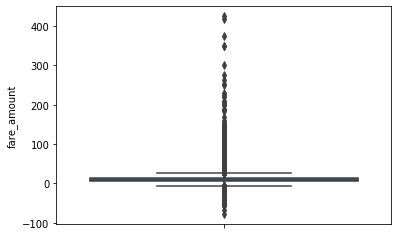

In [183]:
import seaborn as sns
sns.boxplot(y=taxi_med['fare_amount'])
#this shows some very clear outliers in our data. 

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,winter,spring,summer,fall
26027,2.0,2019-04-02 12:39:52,2019-04-02 13:41:04,3.0,40.30,3.0,N,132,1,2.0,...,0.0,0.00,10.50,0.3,134.30,0.0,0,1,0,0
32862,2.0,2019-05-12 16:24:19,2019-05-12 17:38:14,4.0,41.95,5.0,N,132,265,1.0,...,0.0,10.00,24.74,0.3,460.04,0.0,0,1,0,0
37184,1.0,2019-05-09 11:42:50,2019-05-09 13:02:29,1.0,51.40,1.0,N,138,138,1.0,...,0.5,15.00,0.00,0.3,154.30,0.0,0,1,0,0
53291,2.0,2019-08-20 15:12:19,2019-08-20 17:24:43,1.0,95.29,1.0,N,132,265,1.0,...,0.5,50.56,0.00,0.3,303.36,0.0,0,0,1,0
68751,2.0,2019-10-12 00:24:38,2019-10-12 02:10:02,1.0,76.01,5.0,N,10,265,1.0,...,0.5,40.66,0.00,0.3,243.96,2.5,0,0,0,1
72142,2.0,2019-11-04 23:52:52,2019-11-05 00:38:42,2.0,40.50,5.0,N,132,265,1.0,...,0.5,9.00,6.12,0.3,200.92,0.0,0,0,0,1
74900,1.0,2019-11-09 15:31:58,2019-11-09 17:29:44,1.0,93.60,5.0,N,132,265,1.0,...,0.0,5.00,30.54,0.3,310.84,0.0,0,0,0,1
79683,2.0,2019-12-17 13:48:49,2019-12-17 15:26:43,1.0,42.14,5.0,N,132,265,1.0,...,0.0,27.00,16.62,0.3,201.92,0.0,1,0,0,0
80668,2.0,2019-12-14 22:07:57,2019-12-15 00:24:01,1.0,91.41,4.0,N,114,265,2.0,...,0.5,0.00,10.50,0.3,277.80,2.5,1,0,0,0


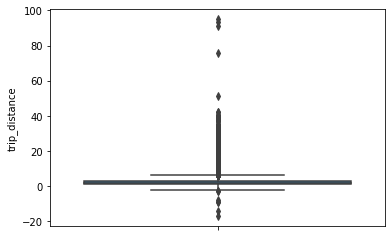

In [184]:
sns.boxplot(y = taxi_med['trip_distance'])


taxi_med[ taxi_med['trip_distance'] > 40]
#we have only 9 instances where the trip was more than 40 miles


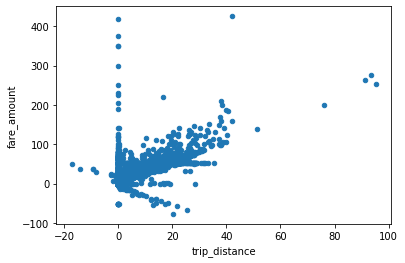

In [185]:
taxi_med.plot.scatter(x='trip_distance', y='fare_amount')

' this scatter plot isnt the most usefull however it does show us that we have several of our fate outliers \nin the same zone. '

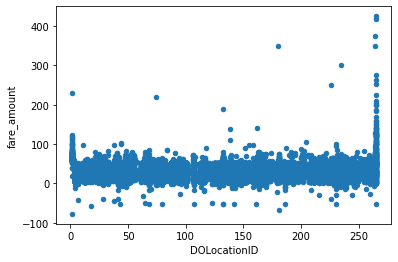

In [186]:
'''we can see with teh scatter plot that some rides with a distance of 0 miles had positive fares. 
We need to clean up these.
Otherwise, there is an overall correlation between distance and fare showing that distance is a fare predictor
'''

#show DO location with fare
taxi_med.plot.scatter(x='DOLocationID', y='fare_amount')
''' this scatter plot isnt the most usefull however it does show us that we have several of our fate outliers 
in the same zone. '''

## Determine distribution of fares

In [209]:
# Determine distribution of fares
print(taxi_clean.groupby('fare_amount').size().nlargest(20))

# $52 is the fixed fare for airport, and most fares are between $6-$13, which means most rides are within Manhattan

fare_amount
6.0     41191
6.5     40723
7.0     39973
5.5     39744
7.5     38268
5.0     36794
8.0     36600
8.5     34109
9.0     31984
4.5     29895
9.5     29500
10.0    27853
10.5    25577
11.0    23149
52.0    22398
11.5    20987
4.0     20846
12.0    19530
12.5    17497
13.0    16102
dtype: int64


' $52 is the fixed fare for airport, and most fares are between $6-$13, which means most rides are within Manhattan'

## Bin and plot histogram (for fares)

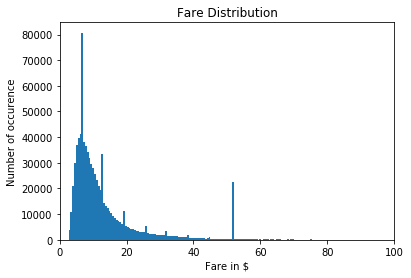

In [229]:
plt.hist(taxi_clean.fare_amount, 1000)
plt.title('Fare Distribution')
plt.xlabel('Fare in $')
plt.ylabel('Number of occurence')
plt.xlim(0, 100)
plt.show();

## Determine distribution of PULocationID and DOLocationID

In [244]:
# Top 5 pickup zone and borough
pu = pd.DataFrame(taxi_clean.groupby('PULocationID').size().nlargest(5))
print('\nTop 5 pickup borough and zone\n',pu.join(other = taxi_zones.set_index("LocationID"), on = "PULocationID", how = "left"))

# Top 5 dropoff zone and borough
do = pd.DataFrame(taxi_clean.groupby('DOLocationID').size().nlargest(5))
print('\nTop 5 dropoff borough and zone\n',do.join(other = taxi_zones.set_index("LocationID"), on = "DOLocationID", how = "left"))

# Most pickups and dropoffs are within Manhattan


Top 5 pickup borough and zone
                   0    Borough                          Zone service_zone
PULocationID                                                             
237           36179  Manhattan         Upper East Side South  Yellow Zone
161           34056  Manhattan                Midtown Center  Yellow Zone
236           32814  Manhattan         Upper East Side North  Yellow Zone
186           30286  Manhattan  Penn Station/Madison Sq West  Yellow Zone
162           30224  Manhattan                  Midtown East  Yellow Zone

Top 5 dropoff borough and zone
                   0    Borough                       Zone service_zone
DOLocationID                                                          
236           34108  Manhattan      Upper East Side North  Yellow Zone
161           32652  Manhattan             Midtown Center  Yellow Zone
237           32209  Manhattan      Upper East Side South  Yellow Zone
170           26260  Manhattan                Murray Hill  Yel

## Determine distribution of trip distance and passengers

trip_distance
0.8    16326
0.9    16311
1.0    16085
0.7    15394
1.1    15336
1.2    14657
0.6    13873
1.3    13421
1.4    12586
1.5    11837
dtype: int64 

passenger_count
1.0    584464
2.0    127204
3.0     35344
5.0     33807
6.0     20170
4.0     17152
0.0     15154
8.0         5
7.0         4
9.0         2
dtype: int64 



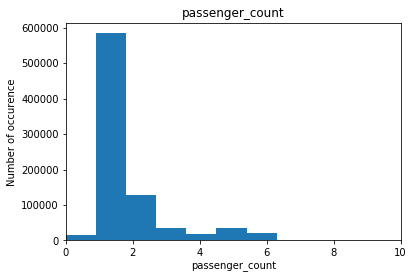

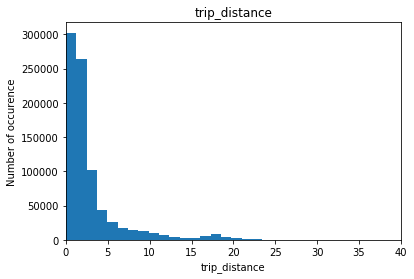

In [278]:
print(taxi_clean.groupby('trip_distance').size().nlargest(10),'\n')
print(taxi_clean.groupby('passenger_count').size().nlargest(10),'\n')

plt.hist(taxi_clean.passenger_count, 10)
plt.title('passenger_count')
plt.xlabel('passenger_count')
plt.ylabel('Number of occurence')
plt.xlim(0, 10)
plt.show();
 
# Most trips are with 0-6 passengers, 0 because passenger information is reported by drivers and they might have missed it

plt.hist(taxi_clean.trip_distance, 100)
plt.title('trip_distance')
plt.xlabel('trip_distance')
plt.ylabel('Number of occurence')
plt.xlim(0, 40)
plt.show();

# Most trips are less than 1.5 miles which means fares will be impacted by traffic conditions

## Exploring location

The "shape file" found here contains some information about the zones: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

Somehow, uploading all of them to this site out puts a csv with latitudes and longitudes 

https://mygeodata.cloud/

Uses coordinate system: EPSG:4269

Credit to this person, that did this project before us: https://chih-ling-hsu.github.io/2018/05/14/NYC

In [187]:
zones_latlong = pd.read_csv("taxi_zones-latlong.csv")

In [188]:
zones_latlong.head()

,X,Y,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough
0,9.352230e+05,190535.0526,1,0.116357,0.000782,Newark Airport,1,EWR
1,1.032516e+06,167292.4932,2,0.433470,0.004866,Jamaica Bay,2,Queens
2,1.025883e+06,254779.6006,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx
3,9.906188e+05,203105.5323,4,0.043567,0.000112,Alphabet City,4,Manhattan
4,9.314680e+05,139837.4784,5,0.092146,0.000498,Arden Heights,5,Staten Island


### Join the lat/ long for each zone, dropping unneccessary columns 

In [190]:
lat_long_fare = taxi_clean.join(other = zones_latlong.set_index("LocationID")[["X","Y"]], on = "PULocationID", how ="left")[["X","Y","fare_amount"]]
lat_long_fare.rename({"X":"Latitude", "Y": "Longitude"}, axis = 1, inplace = True)
lat_long_fare

,Latitude,Longitude,fare_amount
0,1.010930e+06,211369.8834,6.5
1,9.968350e+05,218174.7900,7.0
2,9.919669e+05,215006.4597,14.5
3,9.961663e+05,223633.8650,5.5
4,9.822611e+05,203550.7913,7.5
...,...,...,...
843979,9.863405e+05,211966.8662,15.0
843980,9.868888e+05,208992.9156,12.5
843981,9.870599e+05,216980.2975,21.0
843982,9.886337e+05,216109.0411,6.0


## Make a dataframe that includes pickup and dropoff longitude and latitude

In [196]:
# make a couple of data framees for pick up and dropooff location
PU_lat_long = taxi_large.join(other = zones_latlong.set_index("LocationID")[["X","Y"]], on = "PULocationID", how ="left")[["X","Y"]]
PU_lat_long.rename({"X":"Pickup_Latitude", "Y": "Pickup_Longitude"}, axis = 1, inplace = True)
DO_lat_long = taxi_large.join(other = zones_latlong.set_index("LocationID")[["X","Y"]], on = "DOLocationID", how ="left")[["X","Y"]]
DO_lat_long.rename({"X":"Dropoff_Latitude", "Y": "Dropoff_Longitude"}, axis = 1, inplace = True)

In [197]:
# join the dataframes
PU_DO_lat_long = PU_lat_long.join(other = DO_lat_long, how = "inner")
PU_DO_lat_long.head()

,Pickup_Latitude,Pickup_Longitude,Dropoff_Latitude,Dropoff_Longitude
0,1.010930e+06,211369.8834,1.003837e+06,207164.4234
1,9.968350e+05,218174.7900,9.937533e+05,219279.1627
2,9.919669e+05,215006.4597,9.937844e+05,224349.9169
3,9.961663e+05,223633.8650,9.994917e+05,227336.8825
4,9.822611e+05,203550.7913,9.857388e+05,206141.0082


In [198]:
# calculate traveled latitude and longitude
PU_DO_lat_long["Latitude Traveled"] = abs(PU_DO_lat_long["Pickup_Latitude"] - PU_DO_lat_long["Dropoff_Latitude"])
PU_DO_lat_long["Longtude Traveled"] = abs(PU_DO_lat_long["Pickup_Longitude"] - PU_DO_lat_long["Dropoff_Longitude"])
PU_DO_lat_long.head()

,Pickup_Latitude,Pickup_Longitude,Dropoff_Latitude,Dropoff_Longitude,Latitude Traveled,Longtude Traveled
0,1.010930e+06,211369.8834,1.003837e+06,207164.4234,7092.2330,4205.4600
1,9.968350e+05,218174.7900,9.937533e+05,219279.1627,3081.7215,1104.3727
2,9.919669e+05,215006.4597,9.937844e+05,224349.9169,1817.4261,9343.4572
3,9.961663e+05,223633.8650,9.994917e+05,227336.8825,3325.3793,3703.0175
4,9.822611e+05,203550.7913,9.857388e+05,206141.0082,3477.6911,2590.2169


### Determine Boundary

In [203]:
print("Longitude Boundary in reduced data")
min_long = min(PU_DO_lat_long['Pickup_Longitude'].min(), PU_DO_lat_long['Dropoff_Longitude'].min())
max_long = max(PU_DO_lat_long['Pickup_Longitude'].max(), PU_DO_lat_long['Dropoff_Longitude'].max())
print('Min:',min_long,', Max:',max_long)

print("\nLatitude Boundary in reduced data")
min_lat = min(PU_DO_lat_long['Pickup_Latitude'].min(), PU_DO_lat_long['Dropoff_Latitude'].min())
max_lat = max(PU_DO_lat_long['Pickup_Latitude'].max(), PU_DO_lat_long['Dropoff_Latitude'].max())
print('Min:',min_lat,', Max:',max_lat)

Longitude Boundary in reduced data
Min: 131469.1414 , Max: 267135.0299

Latitude Boundary in reduced data
Min: 920436.3369 , Max: 1064866.095


### This pivot table will have latitude on the Y axis and longitude on the X axis

In [141]:
pivot = lat_long_fare.pivot_table(values = "fare_amount", index = "Latitude", columns = "Longitude")
pivot

Longitude,131469.1414,139837.4784,142929.9855,149456.6732,149700.8641,150502.7459,150686.8185,151388.4311,152667.3989,153009.2606,...,257767.3374,258295.0956,258436.3238,258762.4175,258960.9358,260590.4019,261091.6499,265281.3527,266878.0340,267135.0299
Latitude,,,,,,,,,,,,,,,,,,,,,
9.204363e+05,28.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.314680e+05,NaN,64.583333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.321097e+05,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.352230e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.399781e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.057297e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.057584e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.058662e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### There are a ton of Null values because some of the latitudes and longitude pairs are not valid pickup locations, so no one has ever been picked up there. Fill them with zeroes

In [142]:
pivot.fillna(0, inplace = True)

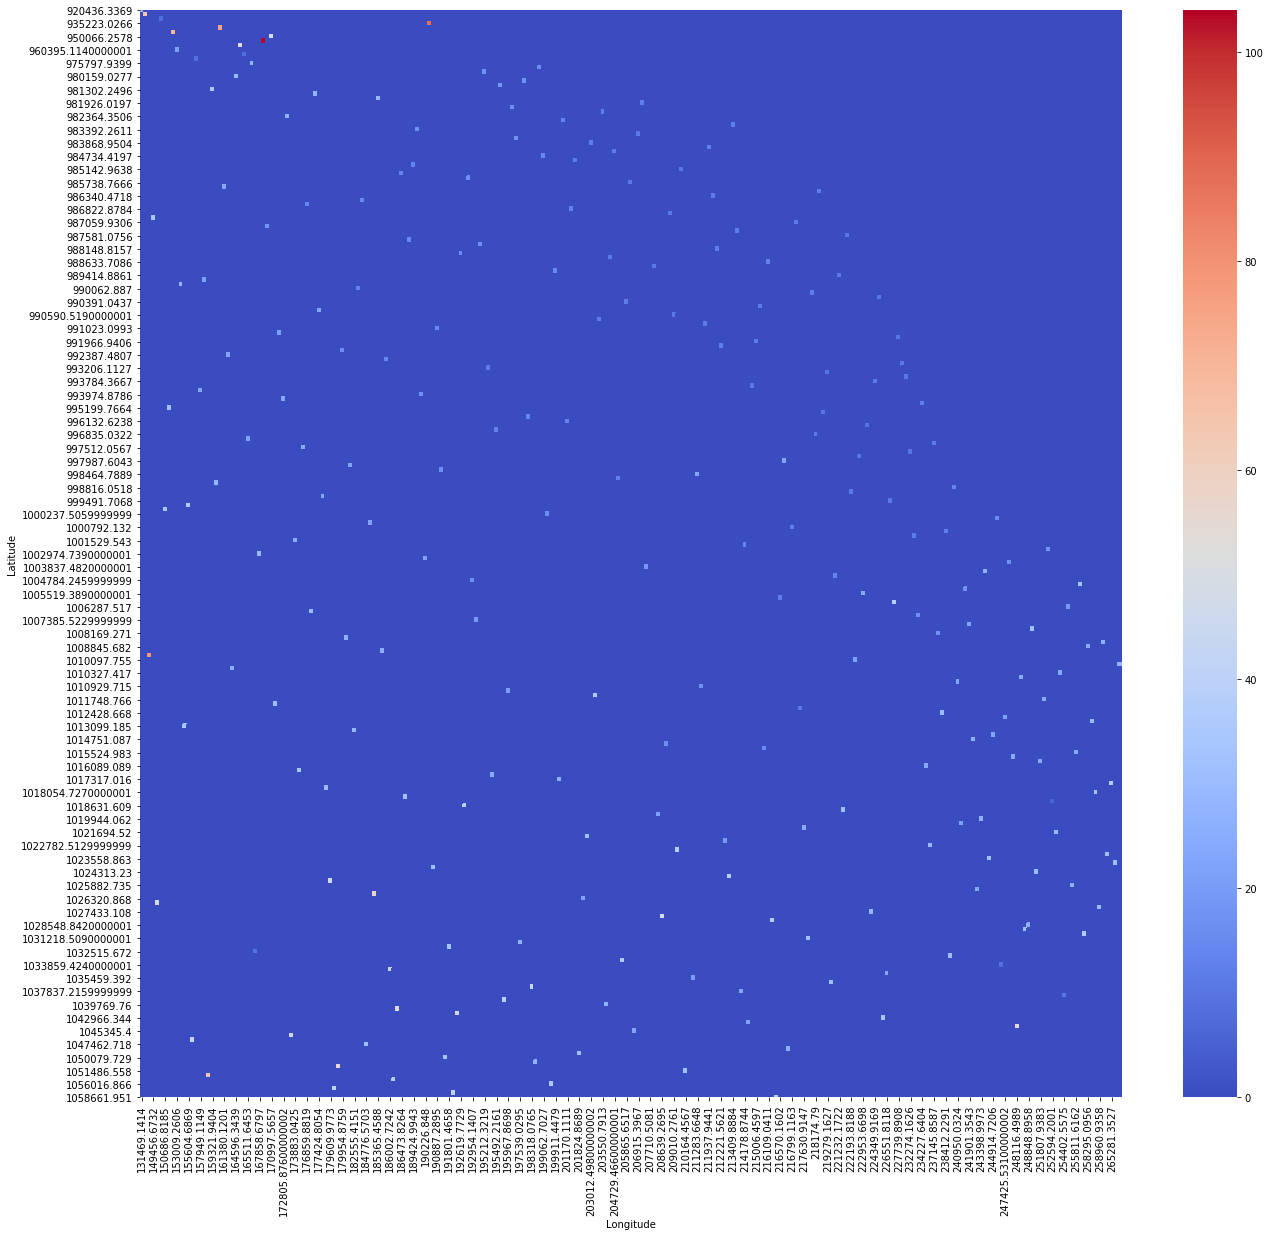

In [143]:
plt.figure(figsize=(22,20))
sns.heatmap(pivot, cmap="coolwarm")

### Look at average fare at each pickup latitude

In [144]:
import seaborn as sns

In [145]:
lat_fare = lat_long_fare.groupby("Latitude").mean()["fare_amount"]
lat_fare.head()

Latitude
920436.3369    28.666667
931467.9628    64.583333
932109.6899     8.000000
935223.0266    88.000649
939978.1196    75.794000
Name: fare_amount, dtype: float64

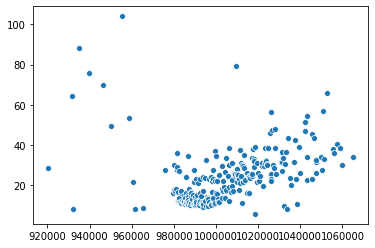

In [146]:
sns.scatterplot(data = lat_fare)

### Fit a linear regression to fare and latitude and plot the resulting line

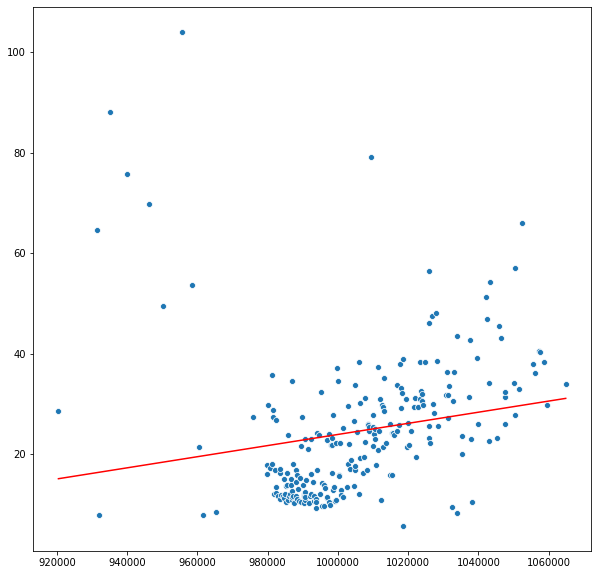

In [147]:
lf = pd.DataFrame(lat_fare).reset_index()

import numpy as np
X_lat = np.array(lf['Latitude']).reshape(-1, 1)
y_lat = np.array(lf['fare_amount']).reshape(-1, 1)

from sklearn.linear_model import LinearRegression
lm = LinearRegression().fit(X_lat, y_lat)

X_plot = np.linspace(X_lat.min(), X_lat.max(), 100)
Y_plot = lm.coef_*X_plot+lm.intercept_
plt.figure(figsize = (10,10))
sns.scatterplot(data = lat_fare)
plt.plot(X_plot,Y_plot[0], color = "red")

### Looks like there is a weak positive correlation between latitude and fare

## Do the same thing for longitude

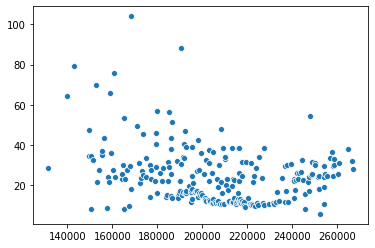

In [148]:
long_fare = lat_long_fare.groupby("Longitude").mean()["fare_amount"]
sns.scatterplot(data = long_fare)

## Looks like there is a weak negative correlation between Longitude and fare

### Fit another regression

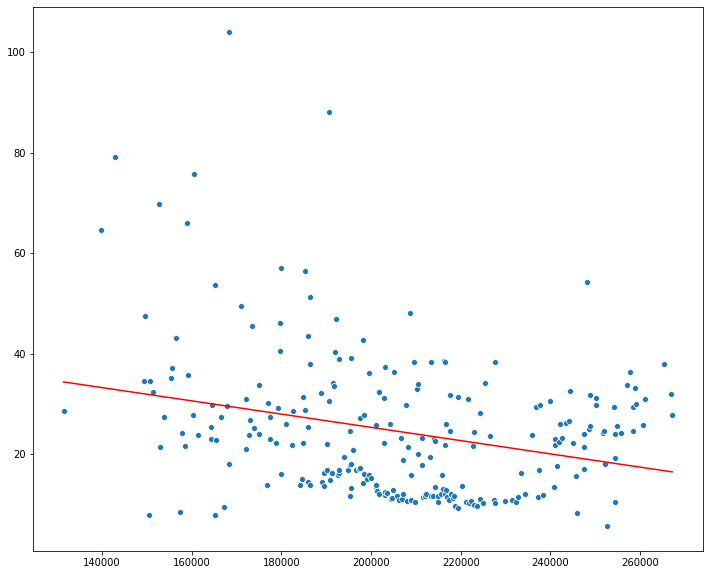

In [149]:
lf2 = pd.DataFrame(long_fare).reset_index()

X_lon = np.array(lf2['Longitude']).reshape(-1, 1)
y_lon = np.array(lf2['fare_amount']).reshape(-1, 1)

lm2 = LinearRegression().fit(X_lon, y_lon)

X_plot2 = np.linspace(X_lon.min(), X_lon.max(), 2)
Y_plot2 = lm2.coef_*X_plot2+lm2.intercept_
plt.figure(figsize = (12,10))
sns.scatterplot(data = long_fare)
plt.plot(X_plot2,Y_plot2[0], color = "red")

### Look at mean fares in the different seasons

In [150]:
winter = taxi_clean[taxi_clean["winter"]==1]
spring = taxi_clean[taxi_clean["spring"]==1]
summer = taxi_clean[taxi_clean["summer"]==1]
fall = taxi_clean[taxi_clean["fall"]==1]

In [155]:
round(winter["fare_amount"].mean(),2)

12.8

In [156]:
len(winter.index)

213751

In [157]:
round(spring["fare_amount"].mean(),2)

13.24

In [158]:
len(spring)

226215

In [160]:
round(summer["fare_amount"].mean(),2)

13.72

In [161]:
round(fall["fare_amount"].mean(),2)

13.69

In [163]:
len(fall.index)

204385

## look at holidays

https://www.kaggle.com/gsnehaa21/federal-holidays-usa-19662020/data#

In [322]:
hol = pd.read_csv("usholidays.csv").drop("Unnamed: 0",1)

# only 10 unique holidays
hol_unique = hol.iloc[0:10]

hol = hol_unique
hol['month'], hol['day'] = hol["Date"].apply(lambda date: date.split('-')[1]),hol["Date"].apply(lambda date: date.split('-')[2])

hol['date'] = '2019-'+hol['month']+'-'+hol['day']

hol.drop('Date',1,inplace = True)

hol['hol_date'] = pd.to_datetime(hol['date'])
hol.drop(['month','day','date'],1,inplace = True)
hol.drop([2,6], inplace = True)
hol.loc[10]=({"Holiday":"St. Patricks", "hol_date":pd.to_datetime('2019-3-19')})
hol.loc[11]=({"Holiday":"UN Convenes", "hol_date":pd.to_datetime('2019-9-23')})
hol.loc[12]=({"Holiday":"UN Ajourns", "hol_date":pd.to_datetime('2019-3-27')})
hol.loc[13]=({"Holiday":"New Year's '18", "hol_date":pd.to_datetime('2019-1-01')})
hol

,Holiday,hol_date
0,New Year's Day,2019-12-31
1,"Birthday of Martin Luther King, Jr.",2019-01-17
3,Memorial Day,2019-05-30
4,Independence Day,2019-07-04
5,Labor Day,2019-09-05
7,Veterans Day,2019-11-11
8,Thanksgiving Day,2019-11-24
9,Christmas Day,2019-12-26
10,St. Patricks,2019-03-19
11,UN Convenes,2019-09-23


In [324]:
# takes about 5 minutes to run this one
for ind in hol.index:
  hol_name = hol.loc[ind][0]
  hol_date = hol.loc[ind][1]
  print(hol_name+"\n")
  taxi_clean[hol_name+" proximity"] = taxi_clean["pickup_datetime"].apply(
      lambda ride_date:int((abs(ride_date-hol_date)<timedelta(days = 3))))

New Year's Day

Birthday of Martin Luther King, Jr.

Memorial Day

Independence Day

Labor Day

Veterans Day

Thanksgiving Day

Christmas Day

St. Patricks

UN Convenes

UN Ajourns

New Year's '18



In [354]:
taxi_clean.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'winter', 'spring', 'summer',
       'fall', 'pickup_datetime', 'dropoff_datetime', 'ride_duration',
       'New Year's Day proximity',
       'Birthday of Martin Luther King, Jr. proximity',
       'Memorial Day proximity', 'Independence Day proximity',
       'Labor Day proximity', 'Veterans Day proximity',
       'Thanksgiving Day proximity', 'Christmas Day proximity',
       'St. Patricks proximity', 'UN Convenes proximity',
       'UN Ajourns proximity', 'New Year's '18 proximity',
       'Holiday Proximity'],
      dtype='object')

In [347]:
holiday_prox = ["New Year's Day proximity",'Birthday of Martin Luther King, Jr. proximity','Memorial Day proximity', 
                'Independence Day proximity','Labor Day proximity', 'Veterans Day proximity','Thanksgiving Day proximity', 
                'Christmas Day proximity','St. Patricks proximity', 'UN Convenes proximity','UN Ajourns proximity',
               "New Year's '18 proximity"]
taxi_clean["Holiday Proximity"] = taxi_clean[holiday_prox].apply(lambda ride_prox: int(sum(ride_prox)>0),1)

In [350]:
taxi_clean.to_csv(r"taxi-lg-clean-holiday.csv")

In [351]:
close_to_holiday = taxi_clean[taxi_clean["Holiday Proximity"]==1]

In [360]:
far_from_holiday = taxi_clean[taxi_clean["Holiday Proximity"]==0]

In [361]:
close_to_holiday["fare_amount"].mean()

13.399473986594273

In [364]:
far_from_holiday["fare_amount"].mean()

13.336185739791498

In [365]:
len(close_to_holiday.index)

140985

In [366]:
len(far_from_holiday.index)

694520

## 6 cent difference between the average fare during the holidays and not during the holidays

In [318]:
taxi_clean[taxi_clean["Thanksgiving Day proximity"]==1]['pickup_datetime'].min()

Timestamp('2019-11-21 00:00:30')

In [367]:
taxi_clean[taxi_clean["Thanksgiving Day proximity"]==1]['pickup_datetime'].max()

Timestamp('2019-11-26 23:59:54')

## Identify date/time outliers

In [75]:
# separate the date and time into separate columns
taxi_med['pickup_datetime'] = pd.to_datetime(taxi_med['tpep_pickup_datetime'])
taxi_med['dropoff_datetime'] = pd.to_datetime(taxi_med['tpep_dropoff_datetime'])
taxi_med.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,summer,fall,Dates,Time,Pick up dates,Pick up times,Drop off dates,Drop off times,pickup_datetime,dropoff_datetime
0,2.0,2019-01-09 00:43:42,2019-01-09 00:52:16,1.0,1.81,1.0,N,142,229,1.0,...,0,0,2019-01-09,00:43:42,2019-01-09,2019-01-09 00:43:42,2019-01-09,2019-01-09 00:52:16,2019-01-09 00:43:42,2019-01-09 00:52:16
1,1.0,2019-01-01 04:03:20,2019-01-01 04:18:54,1.0,4.30,1.0,N,140,202,1.0,...,0,0,2019-01-01,04:03:20,2019-01-01,2019-01-01 04:03:20,2019-01-01,2019-01-01 04:18:54,2019-01-01 04:03:20,2019-01-01 04:18:54
2,2.0,2019-01-26 02:19:33,2019-01-26 02:25:37,1.0,1.56,1.0,N,164,68,1.0,...,0,0,2019-01-26,02:19:33,2019-01-26,2019-01-26 02:19:33,2019-01-26,2019-01-26 02:25:37,2019-01-26 02:19:33,2019-01-26 02:25:37
3,1.0,2019-01-07 16:10:33,2019-01-07 16:26:20,1.0,0.80,1.0,N,170,230,2.0,...,0,0,2019-01-07,16:10:33,2019-01-07,2019-01-07 16:10:33,2019-01-07,2019-01-07 16:26:20,2019-01-07 16:10:33,2019-01-07 16:26:20
4,1.0,2019-01-20 08:58:48,2019-01-20 09:04:30,1.0,0.50,1.0,N,65,65,1.0,...,0,0,2019-01-20,08:58:48,2019-01-20,2019-01-20 08:58:48,2019-01-20,2019-01-20 09:04:30,2019-01-20 08:58:48,2019-01-20 09:04:30


In [76]:
# make a new dataframe with only dates, times, and fares
df = taxi_med[['pickup_datetime','dropoff_datetime','fare_amount']].copy()
df.head()

,pickup_datetime,dropoff_datetime,fare_amount
0,2019-01-09 00:43:42,2019-01-09 00:52:16,8.5
1,2019-01-01 04:03:20,2019-01-01 04:18:54,15.0
2,2019-01-26 02:19:33,2019-01-26 02:25:37,7.0
3,2019-01-07 16:10:33,2019-01-07 16:26:20,10.5
4,2019-01-20 08:58:48,2019-01-20 09:04:30,5.5


We can standardize the fare by dividing the average fare amount by the ride duration and map it to the time that the ride started. So, we'd be left with how much the average ride costs per minute for a given time. This would actually be better to determine if time has an impact on fare

In [175]:
# Sort dataframe by pickup times
# df = df.sort_values(by='pickup_datetime',ascending=True)
# Found that two entries aren't from 2019

from datetime import datetime, date, timedelta
import numpy as np

# Compute ride time
df['ride_duration'] = np.vectorize(lambda drop, pick: drop - pick)(df['dropoff_datetime'], df['pickup_datetime'])

# Drop rides longer than 3 hours
df.drop(df[df['ride_duration'] > timedelta(hours=3)].index, inplace=True)

# Drop rides less than 1 seconds
df.drop(df[df['ride_duration'] < timedelta(seconds=1)].index, inplace=True)

# Convert ride duration to minutes
df['ride_duration'] = list(map(lambda dur: dur.seconds/60, df['ride_duration']))

# Compute fare per minute
df['fare_per_min'] = df['fare_amount'] / df['ride_duration']


fares = [0.0] * 24
rides = [0.0] * 24
for _, row in df.iterrows():
    fares[row['pickup_datetime'].hour] += row['fare_per_min']
    rides[row['pickup_datetime'].hour] += 1
    
hourly_avg_fare_per_min = pd.DataFrame(columns=['average_fare_per_min'])
hourly_avg_fare_per_min['average_fare_per_min'] = list(map(lambda pair: pair[0]/pair[1], zip(fares, rides)))
hourly_avg_fare_per_min

,average_fare_per_min
0,2.001748
1,1.812085
2,1.503321
3,1.333522
4,2.657616
5,2.168571
6,1.382433
7,1.344623
8,1.316673
9,1.382971


Issues found to be fixed:
-Two entries not from 2019
-Some entries that claim pick up and drop off at the same time, with passenger count of 0 and a huge fare (this doesn't mean that a 0 passenger count is always a huge fare, most of the time this is reasonable)
-Passenger count of 0 is very prevalent, cannot use passengers as a feature in the model
-Some rides are very long, but the fare is very cheap. If we are to use the length of the ride as feature, we would have to throw out the rides that are unusually long

## Add pickup and dropoff zone and borough information to taxi_large

In [279]:
df2 = taxi_large.join(other = taxi_zones.set_index("LocationID"), on = "PULocationID", how = "left")
df2 = df2.rename(columns={"Borough": "PU_Borough","Zone": "PU_Zone", "service_zone": "PU_service_zone"})
df3 = df2.join(other = taxi_zones.set_index("LocationID"), on = "DOLocationID", how = "left")
df3 = df3.rename(columns={"Borough": "DO_Borough","Zone": "DO_Zone", "service_zone": "DO_service_zone"})
df3.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,winter,spring,summer,fall,PU_Borough,PU_Zone,PU_service_zone,DO_Borough,DO_Zone,DO_service_zone
0,1.0,2019-01-12 11:22:29,2019-01-12 11:29:48,2.0,0.90,1.0,N,260,226,2.0,...,1,0,0,0,Queens,Woodside,Boro Zone,Queens,Sunnyside,Boro Zone
1,2.0,2019-01-10 18:49:12,2019-01-10 18:57:21,1.0,1.01,1.0,N,140,237,1.0,...,1,0,0,0,Manhattan,Lenox Hill East,Yellow Zone,Manhattan,Upper East Side South,Yellow Zone
2,2.0,2019-01-29 12:55:07,2019-01-29 13:15:27,1.0,2.64,1.0,N,162,43,2.0,...,1,0,0,0,Manhattan,Midtown East,Yellow Zone,Manhattan,Central Park,Yellow Zone
3,1.0,2019-01-11 18:07:20,2019-01-11 18:11:42,1.0,1.00,1.0,N,236,75,1.0,...,1,0,0,0,Manhattan,Upper East Side North,Yellow Zone,Manhattan,East Harlem South,Boro Zone
4,2.0,2019-01-18 09:06:26,2019-01-18 09:16:14,1.0,1.59,1.0,N,125,113,2.0,...,1,0,0,0,Manhattan,Hudson Sq,Yellow Zone,Manhattan,Greenwich Village North,Yellow Zone


In [280]:
# separate the date and time into separate columns
df3['pickup_datetime'] = pd.to_datetime(df3['tpep_pickup_datetime'])
df3['dropoff_datetime'] = pd.to_datetime(df3['tpep_dropoff_datetime'])

# make a new dataframe with fares
df4 = df3[['pickup_datetime','dropoff_datetime','fare_amount','PULocationID','PU_Zone','DOLocationID','DO_Zone']].copy()
df4['ride_duration'] = np.vectorize(lambda drop, pick: drop - pick)(df3['dropoff_datetime'], df3['pickup_datetime'])

# Convert ride duration to seconds
df4['ride_duration'] = list(map(lambda dur: dur.seconds, df4['ride_duration']))

df4.head()

,pickup_datetime,dropoff_datetime,fare_amount,PULocationID,PU_Zone,DOLocationID,DO_Zone,ride_duration
0,2019-01-12 11:22:29,2019-01-12 11:29:48,6.5,260,Woodside,226,Sunnyside,439
1,2019-01-10 18:49:12,2019-01-10 18:57:21,7.0,140,Lenox Hill East,237,Upper East Side South,489
2,2019-01-29 12:55:07,2019-01-29 13:15:27,14.5,162,Midtown East,43,Central Park,1220
3,2019-01-11 18:07:20,2019-01-11 18:11:42,5.5,236,Upper East Side North,75,East Harlem South,262
4,2019-01-18 09:06:26,2019-01-18 09:16:14,7.5,125,Hudson Sq,113,Greenwich Village North,588


## Need to determine baseline model

## Linear Regression on PULocationID PULocationID, ride_duration against fare_amount

In [282]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

y = df4['fare_amount']
X = df4.drop(columns=['fare_amount','pickup_datetime','dropoff_datetime','PU_Zone','DO_Zone'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(y_pred)
print("Test RMSE: %.3f" % mean_squared_error(y_test, y_pred) ** 0.5)

[13.75215568 12.28048755 16.24402435 ... 11.93381614 10.82485152
 13.69450951]
Test RMSE: 12.024
